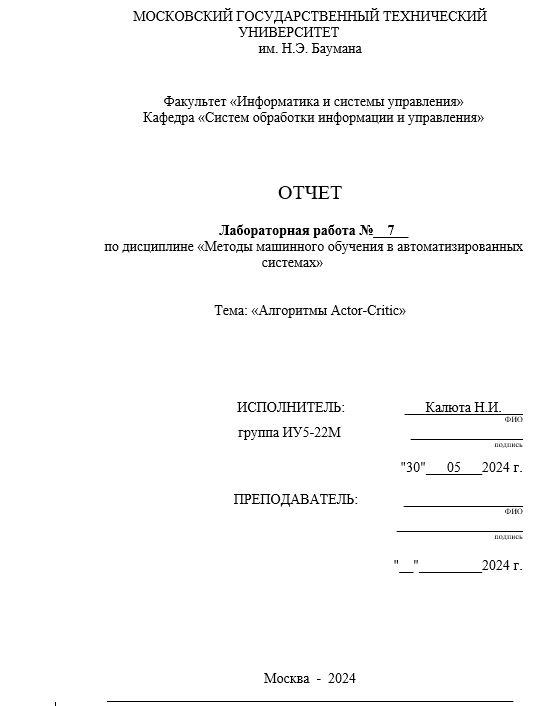

###**Цель лабораторной работы:**
Ознакомление с базовыми методами обучения с подкреплением на основе алгоритмов Actor-Critic.

###**Задание:**
Реализуйте любой алгоритм семейства Actor-Critic для произвольной среды.

Установка библиотек Python

In [12]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

Определяем набор гиперпараметров и констант, которые будут использоваться в дальнейшем коде для реализации алгоритма обучения с подкреплением.

In [13]:
# Гиперпараметры
hidden_size = 256
learning_rate = 3e-4
entropy_coef = 0.01

# Константы
GAMMA = 0.99
num_steps = 250
max_episodes = 2500  # Увеличенное количество эпизодов
CONST_ENV_NAME = "CartPole-v1"
CONST_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Определяем класс ActorCritic, который реализует модель Actor-Critic для обучения с подкреплением

In [14]:
# Класс, реализующий модель Actor-Critic
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)

    def forward(self, state):
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)

        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

    def select_action(self, state):
        _, policy_dist = self.forward(state)
        action = policy_dist.multinomial(num_samples=1).detach()
        return action[0]

 Реализуем алгоритм Advantage Actor-Critic (A2C) для обучения агента в среде с ограниченным числом шагов. Он создает модель Actor-Critic, состоящую из актора, который выбирает действия, и критика, который оценивает их качество, обучает эту модель с использованием градиентного спуска, и визуализирует результаты обучения в виде графиков наград и длин эпизодов. Код также включает в себя логику для вычисления значений Q и преимуществ, необходимых для обновления весов модели.

In [15]:
# Функция для реализации алгоритма Advantage Actor-Critic (A2C)
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n

    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0, 0]
            dist = policy_dist.detach().numpy()

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            result = env.step(action)
            new_state = result[0]
            reward = result[1]
            done = result[2]

            if isinstance(new_state, tuple):
                new_state = new_state[0]
            new_state = torch.tensor(new_state, dtype=torch.float32).unsqueeze(0)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state

            if done or steps == num_steps - 1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0, 0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break

        # Вычисление значений Q
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval

        # Обновление модели actor-critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + entropy_coef * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

    # Построение графиков результатов
    smoothed_rewards = pd.Series(all_rewards).rolling(10).mean()
    plt.plot(all_rewards, label='Награды')
    plt.plot(smoothed_rewards, label='Сглаженные награды')
    plt.xlabel('Эпизод')
    plt.ylabel('Награда')
    plt.legend()
    plt.show()

    plt.plot(all_lengths, label='Длины эпизодов')
    plt.plot(average_lengths, label='Средние длины')
    plt.xlabel('Эпизод')
    plt.ylabel('Длина эпизода')
    plt.legend()
    plt.show()

    return actor_critic


Определяем функцию play_agent, которая позволяет запустить обученного агента в среде и визуализировать его действия. Функция создает экземпляр среды, загружает обученную модель Actor-Critic, выбирает действия на основе текущего состояния среды, выполняет эти действия и визуализирует процесс. Она продолжает взаимодействие с средой до тех пор, пока не будет достигнуто завершение эпизода. Затем она выводит информацию о выбранных действиях и полученных наградах за весь эпизод.

In [16]:
# Функция для запуска агента в среде с использованием обученной модели
def play_agent(actor_critic):
    '''
    Игра с обученным агентом
    '''
    env2 = gym.make(CONST_ENV_NAME, render_mode='human')
    state = env2.reset()
    if isinstance(state, tuple):
        state = state[0]
    state = torch.tensor(state, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)
    done = False
    res = []
    while not done:
        action = actor_critic.select_action(state)
        action = action.item()
        result = env2.step(action)
        observation = result[0]
        reward = result[1]
        done = result[2]
        truncated = result[3]
        env2.render()

        res.append((action, reward))

        if done or truncated:
            done = True
        else:
            if isinstance(observation, tuple):
                observation = observation[0]
            state = torch.tensor(observation, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)

    print('Данные эпизода: ', res)

Создаем экземпляр игровой среды, вызывает функцию a2c() для обучения модели Actor-Critic на этой среде, а затем вызывает функцию play_agent() для запуска обученного агента в той же среде и визуализации его поведения. Таким образом, этот код позволяет обучить агента с использованием алгоритма A2C и затем наблюдать за его действиями в игровой среде.

episode: 0, reward: 11.0, total length: 10, average length: 10.0 
episode: 10, reward: 12.0, total length: 11, average length: 24.7 
episode: 20, reward: 8.0, total length: 7, average length: 30.2 
episode: 30, reward: 14.0, total length: 13, average length: 34.0 
episode: 40, reward: 20.0, total length: 19, average length: 25.8 
episode: 50, reward: 10.0, total length: 9, average length: 26.3 
episode: 60, reward: 41.0, total length: 40, average length: 24.9 
episode: 70, reward: 14.0, total length: 13, average length: 21.7 
episode: 80, reward: 37.0, total length: 36, average length: 34.4 
episode: 90, reward: 57.0, total length: 56, average length: 36.0 
episode: 100, reward: 64.0, total length: 63, average length: 27.8 
episode: 110, reward: 34.0, total length: 33, average length: 31.7 
episode: 120, reward: 75.0, total length: 74, average length: 26.6 
episode: 130, reward: 18.0, total length: 17, average length: 33.6 
episode: 140, reward: 115.0, total length: 114, average length

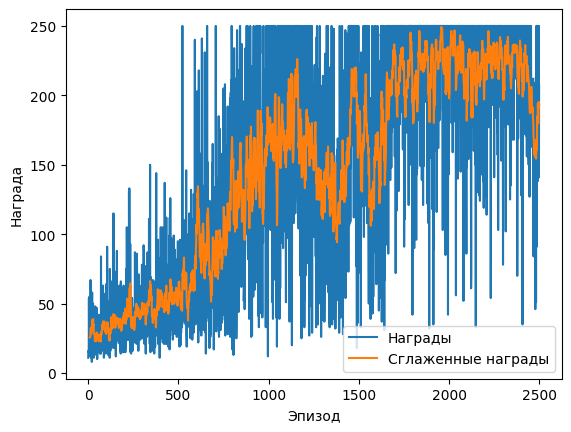

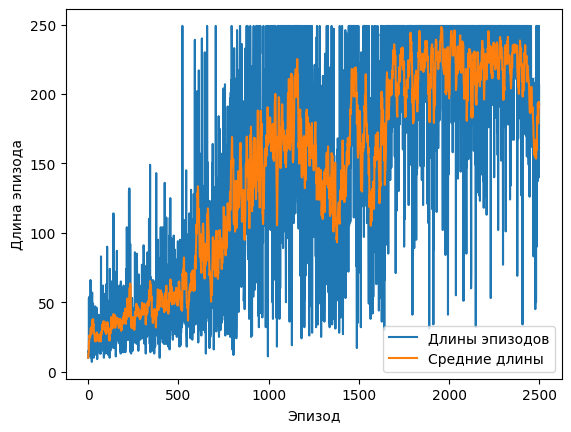

Данные эпизода:  [(1, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (1, 1.0), (0

In [17]:
if __name__ == "__main__":
    env = gym.make(CONST_ENV_NAME)
    trained_actor_critic = a2c(env)

    # Запуск сессии с обученным агентом
    play_agent(trained_actor_critic)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


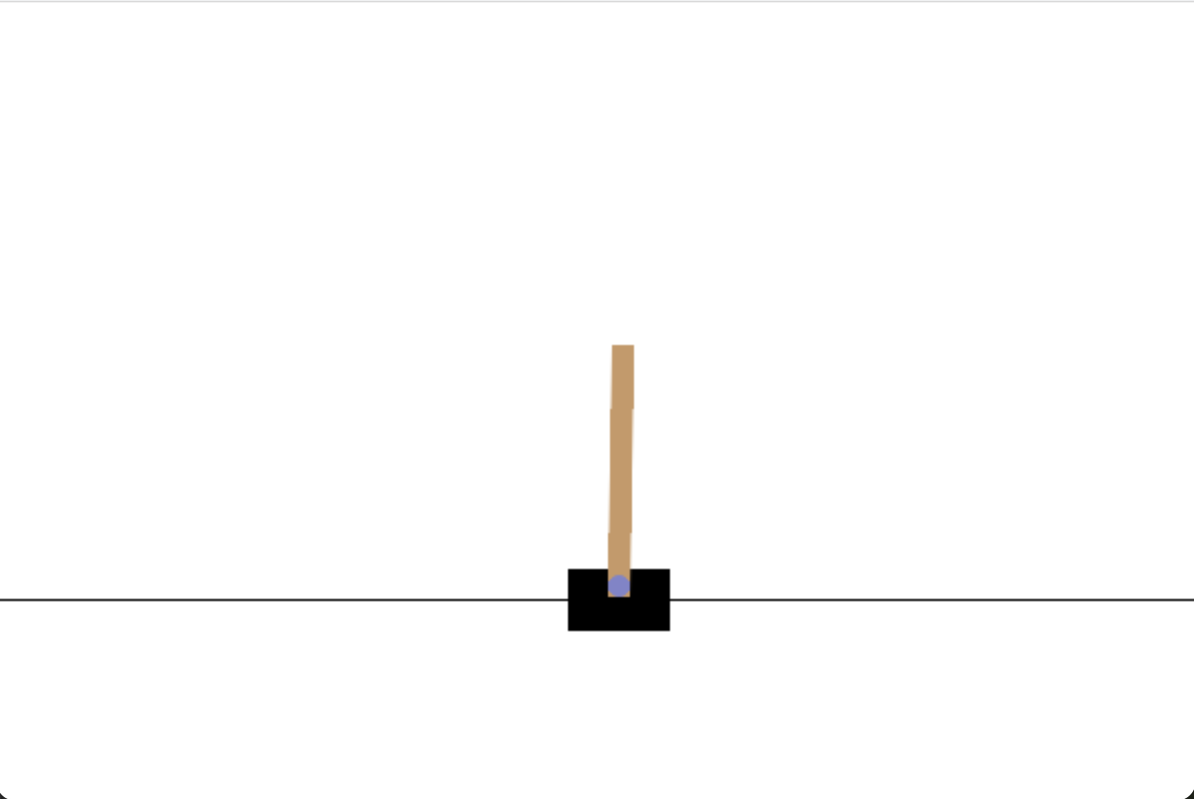

In [19]:
image_path = "/content/drive/MyDrive/Временные файлы/a2c_result.png"
display(Image(filename=image_path, width=500, height=500))

### Итог
Агент был успешно обучен в течение 2500 эпизодов. В процессе обучения наблюдалось улучшение его способности удерживать маятник в вертикальном положении, что подтверждается увеличением наград и длины эпизодов.
Графики, построенные после завершения обучения, показали положительную динамику суммарных наград и средней длины эпизодов, что свидетельствует о корректной работе алгоритма и успешном обучении агента.